In [76]:
# created by G Oldford, Aug 2023

# purpose: run trend analysis for each grid cell for several variables

# second attempt to detect long-term trends from model outputs
# first attempt was using inputs prepped for Ecospace

import xarray as xr
import os
import numpy as np
import pickle
import csv

import cmocean as cm

import mpl_toolkits
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.gridspec as gridspec
from matplotlib import patches

import netCDF4 as nc

# load bathy and tmask for plotting
with nc.Dataset('..//data//bathymetry//bathy_salishsea_1500m_20210706.nc') as bath:
    navlon=bath.variables['nav_lon'][:]
    navlat=bath.variables['nav_lat'][:]
    bathy=bath.variables['Bathymetry'][:]
#     bathy=np.sum(mesh.variables['bathymetry'][0,:])#*mesh.variables['e3t_0'][0,:,:,:],0)
    
with nc.Dataset('..//data//mesh mask//mesh_mask_20210406.nc') as mesh:
#     print(mesh.variables)
    tmask=mesh.variables['tmask'][:]

In [11]:
def make_map(ax, grid, w_map=[-124, -123.9, 47.7, 50.6], rotation=39.2, par_inc=0.25, mer_inc=0.5, fs=7):
    """
    """

    # Make projection
    m = Basemap(ax=ax, 
                projection='lcc', resolution='c',
                lon_0=(w_map[1] - w_map[0]) / 2 + w_map[0] + rotation,
                lat_0=(w_map[3] - w_map[2]) / 2 + w_map[2],
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3])
    
    # Add features and labels
    x, y = m(grid.nav_lon.values, grid.nav_lat.values)
    ax.contourf(x, y, grid.Bathymetry, [-0.01, 0.01], colors='burlywood')
    ax.contour(x, y, grid.Bathymetry, [-0.01, 0.01], colors='black', linewidths=0.1)
#     m.drawmeridians(np.arange(-125.5, -122, mer_inc), labels=[0, 0, 0, 1], linewidth=0.2, fontsize=fs)
    m.drawmeridians(np.arange(-125.5, -122, mer_inc), labels=[0, 0, 0, 0], linewidth=0.2, fontsize=fs)
#     m.drawparallels(np.arange(48, 51, par_inc), labels=[1, 0, 0, 0], linewidth=0.2, fontsize=fs)
    m.drawparallels(np.arange(48, 51, par_inc), labels=[0, 0, 0, 0], linewidth=0.2, fontsize=fs)
    
    return m

def adjust_map(ax):
    
    # set desired width using map units
    # bottom left
    lat_bl, lon_bl = 47.8, -123.2 
    x_bl,y_bl = m(lon_bl,lat_bl)
    # bottom right
    lat_br, lon_br = 48.8, -122.28 
    x_br,_ = m(lon_br,lat_br)
    ax.set_xlim(x_bl, x_br)

    # top left
    lat_tl, lon_tl = 50.3, -124.75
    x_tl, y_tl = m(lon_tl, lat_tl)

    lat_bl, lon_bl = 48.2, -123.5
    x_bl,y_bl = m(lon_bl,lat_bl)
    ax.set_ylim(y_bl, y_tl)

    # fix a little path in bottom right
    lccx_TL, lccy_TL = m(-122.83, 49.4)
    lccx_BR, lccy_BR = m(-122.58, 48.7)
    lccx_BL, lccy_BL = m(-122.33, 48.7)
    lccw = lccx_BL - lccx_BR
    lcch = lccy_TL - lccy_BL

    ax.add_patch(patches.Rectangle(
                (lccx_BL, lccy_BL), lccw, lcch, 
                facecolor='burlywood', edgecolor='k',
                linewidth=0,
                zorder=0))

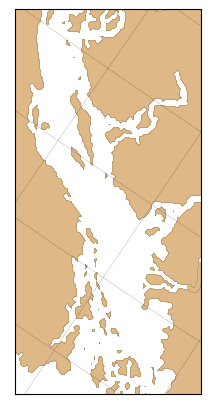

In [14]:
grid_p = '../data/bathymetry/'
grid_f = 'bathy_salishsea_1500m_20210706.nc'
grid = xr.open_dataset(os.path.join(grid_p, grid_f), mask_and_scale=False)
    
fig, ax = plt.subplots(figsize=(5,5)) #w,h
m = make_map(ax,grid,
             w_map=[-130, -115, 41, 60],
             rotation=43,
             par_inc=0.5,
             mer_inc=1
            )

adjust_map(ax)
plt.show()

C:\Users\Greig\anaconda3\lib\site-packages\matplotlib\contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\Greig\anaconda3\lib\site-packages\matplotlib\contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\Greig\anaconda3\lib\site-packages\matplotlib\contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\Greig\anaconda3\lib\site-packages\matplotlib\contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\Greig\anaconda3\lib\site-packages\matplotlib\contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\Greig\anaconda3\lib\site-packages\matplotlib\contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


0.125
0.475


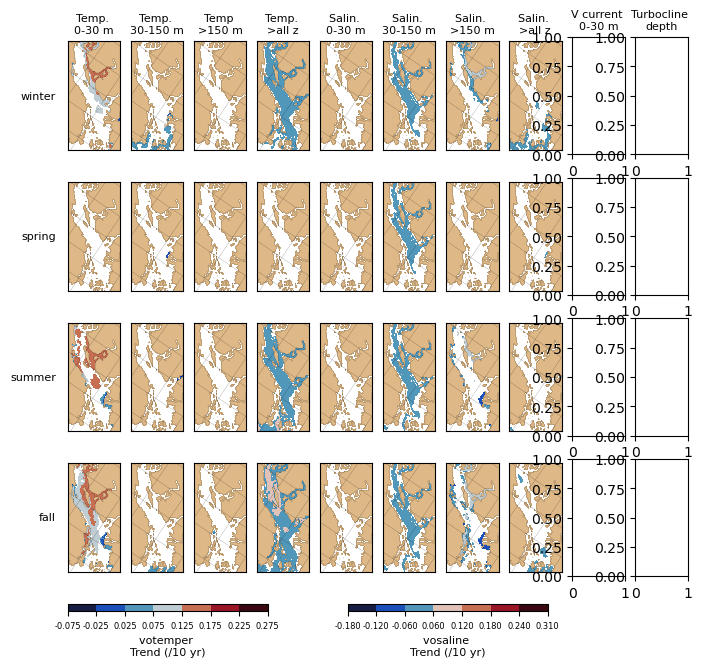

In [128]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

# Create a figure and axis objects for a 5x4 grid
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(8, 7)) # w,h

column_labels = [
    'Temp. \n0-30 m', 'Temp. \n30-150 m', 'Temp \n>150 m', 'Temp. \n>all z',
    'Salin. \n0-30 m', 'Salin. \n30-150 m', 'Salin. \n>150 m', 'Salin. \n>all z', 
    'V current \n0-30 m', 'Turbocline \ndepth'
]

row_labels = ['winter', 'spring', 'summer', 'fall']

# Dictionary to store colorbar handles
colorbars = {}

# label columns
fs1 = 8
for idx, label in enumerate(column_labels):
    ax = axes[0, idx]  # Get the first row and corresponding column index
    ax.set_title(label, fontsize=fs1)
    
# row labels
for idx, label in enumerate(row_labels):
    ax = axes[idx, 0]
    ax.annotate(label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad + 3, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', fontsize=fs1)

# for row in axes:
#     for ax in row:
#         m = make_map(ax,grid,
#                      w_map=[-130, -115, 41, 60],
#                      rotation=43,
#                      par_inc=0.5,
#                      mer_inc=1
#                     )
#         adjust_map(ax)

var_min_max = {}

test_p = 'D:/temp_nemo/trend_output/anom_trend_seasavg/'    
seasons = ['winter', 'spring', 'summer', 'fall']
depth_groups = ["0to30m", "30to150m", "gt150m", "allz"]
variables = ['votemper', 'vosaline']#, 'mldkz5', 'mldr10_1']

num_color_bins = 7
variable_bins = {'votemper':[-0.0075, -0.0025, 0.0025, 0.0075, 0.0125, 0.0175, 0.0225, 0.0275],
                 'vosaline':[-0.018, -0.012, -0.006, 0.006, 0.012, 0.018, 0.024, 0.031]
                }

def custom_formatter(x, pos):
    return f'{x:.3f}'

for variable in variables:
    var_min = np.inf  # Initialize with positive infinity
    var_max = -np.inf  # Initialize with negative infinity

    for season in seasons:
        for depth_group in depth_groups:
            # Load the data for the current variable, depth group, and season
            file_name = f'anom_trend_{variable}_{depth_group}_{season}.nc'
            with nc.Dataset(os.path.join(test_p, file_name)) as test:
                slopes = test.variables['slope'][:]
            
            var_min = min(var_min, np.nanmin(slopes))
            var_max = max(var_max, np.nanmax(slopes))
            
    var_min_max[variable] = (var_min, var_max)


for season_idx, season in enumerate(seasons):
    for depth_idx, depth_group in enumerate(depth_groups):
        for var_idx, variable in enumerate(variables):
            #print((season_idx, depth_idx * len(variables) + var_idx))
            ax = axes[season_idx, depth_idx * len(variables) + var_idx]
            # Load the data for the current variable, depth group, and season
            file_name = f'anom_trend_{variable}_{depth_group}_{season}.nc'
            with nc.Dataset(os.path.join(test_p, file_name)) as test:
                navlon = test.variables['nav_lon'][:]
                navlat = test.variables['nav_lat'][:]
                slopes = test.variables['slope'][:]
                sig_tf = test.variables['sig_tf'][:]
            
            m = make_map(ax, grid,
                         w_map=[-130, -115, 41, 60],
                         rotation=43,
                         par_inc=0.5,
                         mer_inc=1
                        )
            adjust_map(ax)
            slopes = np.ma.masked_where(tmask[0,0,:] == 0, slopes)
            slopes = np.ma.masked_where(sig_tf == 0, slopes)
            slopes = slopes * 10 # scale to decadal
            

            x, y = m(navlon, navlat)
            
            # for data exploration (bins, colors hardcoded after doing it as below)
            min_val = var_min_max[variable][0] * 1.1
            max_val = var_min_max[variable][1] * 1.1
#             c = m.contourf(x, y, slopes, 
#                            cmap=cm.cm.balance, 
#                            #cmap=cmap,
#                            levels=np.linspace(min_val * 10, max_val * 10, num_color_bins)
#                           )
            
            boundaries = variable_bins[variable]
            boundaries = np.multiply(boundaries, 10)
            # the data are not centred on zero
            # so need to manually fiddle
            cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
            c = m.contourf(x, y, slopes, 
                           cmap=cmap_balance, 
                           #cmap=cmap,
                           levels=boundaries
                          )
             
#             # this helps keep '0' values colored white
#             boundaries = np.round(np.arange(min_val, max_val, 0.004),2)
#             # create list of colors from colormap
#             cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
#             colors = list(cmap_balance(np.arange(len(boundaries))))
#             #replace first color with white
#             colors[0] = "white"
#             cmap = mpl.colors.ListedColormap(colors[:-1], "")
#             # set over-color to last color of list 
#             cmap.set_over(colors[-1])
#             norm = mpl.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)
            
            
            
            
            if var_idx not in colorbars and season_idx == len(seasons) - 1:
                # Create a colorbar only once per variable
                strtx_wrt_panel = 0.125 + 0.35 * (var_idx)
                width_wrt_panel = 0.25
                print(strtx_wrt_panel)
                cax = plt.axes([strtx_wrt_panel, 0.06, width_wrt_panel, 0.01]) #,left,bottom, width, height
                colorbars[var_idx] = plt.colorbar(c, cax=cax, 
                                                  orientation='horizontal', 
                                                  format=ticker.FuncFormatter(custom_formatter))
                colorbars[var_idx].set_label(f'{variable} \nTrend (/10 yr)', fontsize=8)  # Customize the label as needed
                colorbars[var_idx].ax.tick_params(labelsize=6)

# divider = make_axes_locatable(axes[0, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.05)
# colorbar = plt.colorbar(c, cax=cax, orientation='horizontal')
# colorbar.set_label('Colorbar Label')  # Customize the label as needed

        
# plt.tight_layout
plt.show()

In [5]:
ex_f = 'SalishSea1500-RUN203_1d_grid_T_y2017m07.nc'
ex_p = '../data/output/RUN203/'

In [114]:
variable_bins = {'votemper':[-0.0075, -0.0025, 0.0025, 0.0075, 0.0125, 0.0175, 0.0225, 0.0275],
                 'vosaline':[-0.018, -0.012, -0.006, 0.006, 0.012, 0.018, 0.024, 0.031]
                }
variable = 'votemper'
boundaries = variable_bins[variable]
cm.cm.balance(boundaries)

TypeError: can only concatenate list (not "int") to list

In [123]:
boundaries = variable_bins[variable]
            # the data are not centred on zero
            # so need to manually fiddle
print(np.prod(boundaries, 0, 10))
cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
colors = list(cmap_balance())
colors
             
#             # this helps keep '0' values colored white
#             boundaries = np.round(np.arange(min_val, max_val, 0.004),2)
#             # create list of colors from colormap
#             cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
#             colors = list(cmap_balance(np.arange(len(boundaries))))
#             #replace first color with white
#             colors[0] = "white"
#             cmap = mpl.colors.ListedColormap(colors[:-1], "")
#             # set over-color to last color of list 
#             cmap.set_over(colors[-1])
#             norm = mpl.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)
            

TypeError: Cannot interpret '10' as a data type

C:\Users\Greig\AppData\Local\Temp\ipykernel_15676\3598029720.py:34: UserWarning: The following kwargs were not used by contour: 'shading'
  c = m.contourf(x, y, slopes, cmap='viridis', shading='auto')


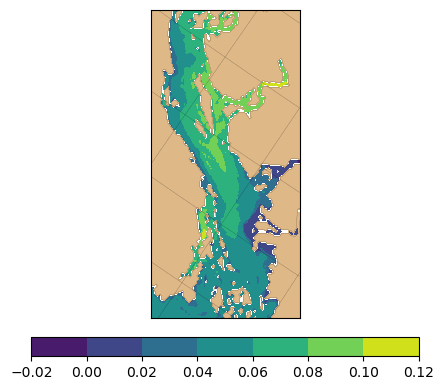

In [9]:
test_f = 'anom_trend_votemper_allz_fall.nc'
test_p = 'D:/temp_nemo/trend_output/anom_trend_seasavg/'

# test_f = 'raw_trend_votemper_0to30m_summer.nc'
# test_p = 'D:/temp_nemo/trend_output/raw_trends/'

grid_p = '../data/bathymetry/'
grid_f = 'bathy_salishsea_1500m_20210706.nc'
grid = xr.open_dataset(os.path.join(grid_p, grid_f), mask_and_scale=False)

with nc.Dataset(os.path.join(test_p, test_f)) as test:
#     print(test.variables)
    navlon=test.variables['nav_lon'][:]
    navlat=test.variables['nav_lat'][:]
    slopes=test.variables['slope'][:]
    sig_tf=test.variables['sig_tf'][:]
#     bathy=np.sum(mesh.variables['bathymetry'][0,:])#*mesh.variables['e3t_0'][0,:,:,:],0)


fig, ax = plt.subplots(figsize=(5,5)) #w,h
m = make_map(ax,grid,
             w_map=[-130, -115, 41, 60],
             rotation=43,
             par_inc=0.5,
             mer_inc=1
            )

adjust_map(ax)
slopes = np.ma.masked_where(tmask[0,0,:] == 0, slopes)
#slopes = np.ma.masked_where(sig_tf == 0, slopes)
slopes = slopes * 10

x, y = m(navlon, navlat)
c = m.contourf(x, y, slopes, cmap='viridis', shading='auto')
colorbar = plt.colorbar(c, orientation='horizontal', pad=0.05)  
plt.show()

In [151]:
test_f = 'raw_trend_votemper_0to30m_winter.nc'
test_p = 'D:/temp_nemo/trend_output/raw_trends/'


(299, 132)

C:\Users\Greig\AppData\Local\Temp\ipykernel_31532\864692591.py:16: UserWarning: The following kwargs were not used by contour: 'shading'
  c = m.contourf(x, y, slopes, cmap='viridis', shading='auto')


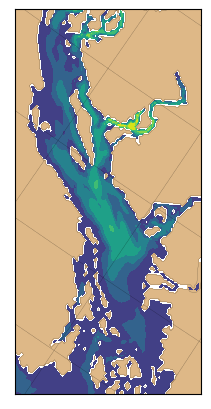